In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import torch
import torchvision
import numpy as np
from nilearn import plotting
import clinicadl
import pandas as pd
import matplotlib.pyplot as plt
from torchinfo import summary
from sklearn.metrics import log_loss
from collections import OrderedDict
from PIL import Image
from tqdm import tqdm
from math import floor
import random
import time
import os
import json

# torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# clinicaDL
from clinicadl.tools.tsv.data_split import create_split
from clinicadl.tools.deep_learning.data import generate_sampler, return_dataset, MRIDataset, get_transforms
from torch.utils.data import DataLoader
from clinicadl.tools.deep_learning.cnn_utils import train, get_criterion, test
from clinicadl.tools.deep_learning.models.random import RandomArchitecture
from clinicadl.tools.deep_learning import EarlyStopping

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

# visualization
from scipy.ndimage import zoom
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt

%matplotlib inline

In [9]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [10]:
from tools.explanations.evaluation import *
from tools.explanations.GradCam import *
from tools.explanations.guided_backprop import *
from train.train_CNN import *
from tools.callbacks import *
from tools.data import *
from tools.explanations.visualization import *
from tools.models.CN5_FC3_3D import *
from tools.settings import *

In [11]:
data_path = '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021.tsv'
summary_path = '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021_summary.tsv'
# df_data = pd.read_csv(data_path,sep='\t',nrows=10)
# df_summary = pd.read_csv(summary_path,sep='\t',nrows=10)

In [12]:
pipeline_name='t1-volume'
atlas_id='AAL2'

# Train Single CNN

## Initialization

In [32]:
# global parameters
caps_directory = '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021/'
batch_size = 16
num_workers = os.cpu_count()
learning_rate = 1e-4
weight_decay = 1e-4

In [33]:
# load dataframes
AD = pd.read_csv('subjects/AD.tsv',sep='\t')
CN = pd.read_csv('subjects/CN.tsv',sep='\t')

# remove samples with NaN
AD.drop(AD[AD.isna().sum(axis=1) > 0].index, inplace=True)
CN.drop(CN[CN.isna().sum(axis=1) > 0].index, inplace=True)

# split data between training and validation sets
training_df, valid_df = create_split('AD', AD, 'diagnosis',0.2)
df_CN = create_split('CN', CN, 'diagnosis',0.2)
training_df = training_df.append(df_CN[0]).reset_index().iloc[np.array([0,1,2,-1,-2,-3])]
valid_df = valid_df.append(df_CN[1]).reset_index().iloc[np.array([0,1,2,-1,-2,-3])]

# drop index column
training_df.drop(columns = ['index'], inplace=True)
valid_df.drop(columns = ['index'], inplace=True)

train_transforms, all_transforms = get_transforms('image', minmaxnormalization=True, data_augmentation=None )
# fetch volumetric data
stds, df_add_data = fetch_add_data(training_df)

# all_transforms = torchvision.transforms.Compose([])

DEBUG:root:p_age=0.28, p_sex=0.8283
DEBUG:root:p_age=0.00, p_sex=0.9114
DEBUG:root:p_age=0.49, p_sex=0.9493
DEBUG:root:p_age=0.77, p_sex=0.8836
DEBUG:root:p_age=0.44, p_sex=0.8559
DEBUG:root:p_age=0.93, p_sex=0.7464
DEBUG:root:p_age=0.18, p_sex=0.9672
DEBUG:root:p_age=0.38, p_sex=0.9393
DEBUG:root:p_age=0.53, p_sex=0.9393
DEBUG:root:p_age=0.35, p_sex=0.9393
DEBUG:root:p_age=0.44, p_sex=0.9951
DEBUG:root:p_age=0.34, p_sex=0.8559
DEBUG:root:p_age=0.86, p_sex=0.9393
INFO:root:Split for diagnosis AD was found after 13 trials
DEBUG:root:p_age=0.84, p_sex=0.7967
DEBUG:root:p_age=0.35, p_sex=0.9954
DEBUG:root:p_age=0.38, p_sex=0.8955
DEBUG:root:p_age=0.21, p_sex=0.9954
DEBUG:root:p_age=0.10, p_sex=0.9050
DEBUG:root:p_age=0.93, p_sex=0.9954
INFO:root:Split for diagnosis CN was found after 6 trials


First column name:  t1-volume_group-adni2021_atlas-AAL2_ROI-Background_intensity
Last column name:  t1-volume_group-adni2021_atlas-AAL2_ROI-Vermis_10_intensity
     participant_id session_id sex   age  \
0  sub-ADNI002S0295    ses-M00   M  84.8   
1  sub-ADNI002S0295    ses-M06   M  85.3   
2  sub-ADNI002S0295    ses-M12   M  85.8   
3  sub-ADNI002S0295    ses-M24   M  87.0   
4  sub-ADNI002S0295    ses-M36   M  87.8   

   t1-volume_group-adni2021_atlas-AAL2_ROI-Precentral_L_intensity  \
0                                           0.267730                
1                                           0.276336                
2                                           0.253523                
3                                           0.259355                
4                                           0.284153                

   t1-volume_group-adni2021_atlas-AAL2_ROI-Precentral_R_intensity  \
0                                           0.219289                
1                     

In [37]:
data_train = MRIDatasetImage(caps_directory, training_df, df_add_data=df_add_data,all_transformations=all_transforms) #train_transformations=all_transforms
data_valid = MRIDatasetImage(caps_directory, valid_df, df_add_data=df_add_data, all_transformations=all_transforms) #train_transformations=all_transforms,


# sampler
train_sampler = generate_sampler(data_train)
valid_sampler = generate_sampler(data_valid)
# loaders
train_loader = DataLoader(data_train,
                         batch_size=batch_size,
                         sampler=train_sampler,
                         num_workers=num_workers,
                         pin_memory=True)

valid_loader = DataLoader(data_valid,
                         batch_size=batch_size,
                         sampler=valid_sampler,
                         num_workers=num_workers,
                         pin_memory=True)

0
0


## Training

In [38]:
# get sample
sample = data_train[0]
# build model
model = Net(sample, [8, 16, 32, 64, 128])
# if torch.cuda.is_available():
#     print("To cuda")
#     model.cuda()
model.summary(batch_size=16)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      --                        --
├─Sequential: 1-1                        [16, 64, 5, 7, 5]         --
│    └─Conv3d: 2-1                       [16, 8, 119, 143, 119]    224
│    └─ReLU: 2-2                         [16, 8, 119, 143, 119]    --
│    └─BatchNorm3d: 2-3                  [16, 8, 119, 143, 119]    16
│    └─MaxPool3d: 2-4                    [16, 8, 59, 71, 59]       --
│    └─Conv3d: 2-5                       [16, 16, 57, 69, 57]      3,472
│    └─ReLU: 2-6                         [16, 16, 57, 69, 57]      --
│    └─BatchNorm3d: 2-7                  [16, 16, 57, 69, 57]      32
│    └─MaxPool3d: 2-8                    [16, 16, 28, 34, 28]      --
│    └─Conv3d: 2-9                       [16, 32, 26, 32, 26]      13,856
│    └─ReLU: 2-10                        [16, 32, 26, 32, 26]      --
│    └─BatchNorm3d: 2-11                 [16, 32, 26, 32, 26]      64
│    └─

In [46]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# record losses
train_losses = dict()
test_losses = dict()

# callbacks
ES = EarlyStopping(patience=5)
MC = ModelCheckpoint()

print("Beginning of the training")

# training
for epoch in range(2):
    update_dict(train_losses, train(epoch, model, optimizer, train_loader, to_cuda=True))
    update_dict(test_losses, test(model, valid_loader, to_cuda=True, rescaling=stds))

Beginning of the training


0it [00:00, ?it/s]


KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 3080, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 1625, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 1632, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 3

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 202, in _worker_loop
    data = fetcher.fetch(index)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/interpretability-dl-ndd/tools/data.py", line 209, in __getitem__
    participant, session, cohort, _, label = self._get_meta_data(idx)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/clinicadl/tools/deep_learning/data.py", line 140, in _get_meta_data
    participant = self.df.loc[image_idx, 'participant_id']
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexing.py", line 889, in __getitem__
    return self._getitem_tuple(key)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexing.py", line 1060, in _getitem_tuple
    return self._getitem_lowerdim(tup)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexing.py", line 807, in _getitem_lowerdim
    section = self._getitem_axis(key, axis=i)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexing.py", line 1124, in _getitem_axis
    return self._get_label(key, axis=axis)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexing.py", line 1073, in _get_label
    return self.obj.xs(label, axis=axis)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/generic.py", line 3739, in xs
    loc = index.get_loc(key)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 3082, in get_loc
    raise KeyError(key) from err
KeyError: 3


In [ ]:
for k in range(1,5):
    print(np.linalg.norm(getattr(getattr(model,'branch' + str(k)), 'b' + str(k) + '-conv').weight.grad.data.cpu()))

## Loss visualization

In [ ]:
def plot_losses(dict_losses, title=""):
    """
    Plot the different losses.
    
    Args:
        dict_losses: dictionnary of losses
    """
    plt.figure()
    plt.title(title)
    for key in dict_losses.keys():
        plt.plot(dict_losses[key], label=key)
    plt.legend()
    plt.show()
    
def plot_tensor(X):
    x = np.transpose(X[0], (1,2,0))
    x = (x-x.min())/x.max()
    plt.imshow(x)

In [ ]:
metric_path = 'results/models/model_5/'

train_metrics = pd.read_csv(metric_path + 'train_losses.csv')
test_metrics = pd.read_csv(metric_path + 'val_losses.csv')

In [ ]:
plot_losses(train_metrics[['disease']], "Training losses")

In [ ]:
plot_losses(test_metrics[['disease']], "Val losses")

## Explanations

In [7]:
caps_directory = '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021/'
path = 'results/models/model_19/'
training_df = pd.read_csv(os.path.join(path, 'training_df.csv'))
valid_df = pd.read_csv(os.path.join(path, 'valid_df.csv'))

train_transforms, all_transforms = get_transforms('image', minmaxnormalization=True, data_augmentation=None)

# fetch volumetric data
stds, df_add_data = fetch_add_data(training_df)

# all_transforms = torchvision.transforms.Compose([])

data_train = MRIDatasetImage(caps_directory, training_df, df_add_data=df_add_data,
                             all_transformations=all_transforms) 
data_valid = MRIDatasetImage(caps_directory, valid_df, df_add_data=df_add_data,
                             all_transformations=all_transforms)  # train_transformations=all_transforms,

First column name:  t1-volume_group-adni2021_atlas-AAL2_ROI-Background_intensity
Last column name:  t1-volume_group-adni2021_atlas-AAL2_ROI-Vermis_10_intensity


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
sample = data_train[0]
img = sample['image'].float()
img.shape

In [8]:
# load model
saved_data = torch.load(os.path.join(path, 'test_best_model.pt'))

model.load_state_dict(saved_data['model_state_dict'])

# select one image
img = sample['image'].float()

mode = 'cuda'
if mode == 'cuda':
    model = model.cuda()
    img = img.cuda()
else:
    model = model.cpu()
    img = img.cpu()

In [68]:
ar = np.load('results/models/model_19/attribution_maps/GC/val/age/sub-ADNI002S1018_ses-M00.npy')

### Loss visualization

In [3]:
saved_data = torch.load('results/models/model_19/last_model.pt')

In [4]:
saved_data.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss', 'best_loss', 'train_metrics', 'val_metrics'])

In [16]:
train_metrics = saved_data['val_metrics']

In [19]:
train_metrics['b3_MeanSquaredError']

[10.740900039672852,
 8.37081527709961,
 33.91691589355469,
 82.28373718261719,
 28.77964973449707,
 21.143688201904297,
 16.262182235717773,
 19.61556625366211,
 10.508869171142578,
 8.14531135559082,
 91.03712463378906,
 51.513816833496094,
 107.070556640625,
 123.70819854736328,
 21.909709930419922,
 51.294586181640625,
 6.470217704772949,
 31.632925033569336,
 6.6416826248168945,
 6.601271629333496,
 6.524799346923828,
 6.593179702758789,
 6.520787715911865,
 15.977116584777832,
 6.48101806640625,
 6.303374290466309,
 6.631115913391113,
 6.688444137573242,
 6.196437835693359,
 6.953071594238281,
 16.680301666259766,
 6.913064956665039,
 6.533334732055664,
 43.05387878417969,
 11.138813972473145,
 6.076729774475098,
 6.3126044273376465,
 36.24996566772461,
 52.37376403808594,
 28.881973266601562,
 5.843369483947754,
 5.774815082550049,
 5.958796501159668,
 5.991237640380859,
 13.440272331237793,
 5.844188213348389,
 6.305954456329346,
 5.875237464904785,
 5.777097225189209,
 5.75873

<AxesSubplot:>

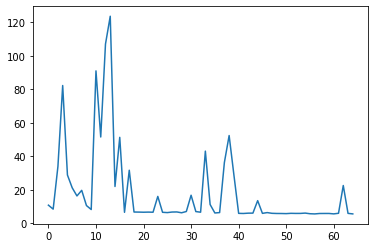

In [17]:
pd.DataFrame(train_metrics)['b3_MeanSquaredError'].plot()

### Guided Backpropagation

In [ ]:
GBP = GuidedBackprop(model)
attention_maps = GBP.generate_gradients(img)

In [ ]:
visualize_explanations(img.cpu(), attention_maps)

### GradCAM

In [60]:
a0 = time.time()
GC = GradCam(model)
img = sample['image']
attentions = GC.get_explanations(img.cuda(), resize=False, to_cpu=True)
print(time.time() - a0)

16.476941347122192


In [11]:
# for key in attentions:
#     attentions[key] = attentions[key].cpu()
visualize_explanations(img, attentions) #, targets='volumes')

Image shape: 169 208 179


interactive(children=(IntSlider(value=103, description='layer', max=207), IntSlider(value=0, description='chan…

In [ ]:
a0 = time.time()
GC = GradCam(model.cuda(), target_layer='conv2')
img = sample['image'].float()
attentions = GC.get_explanations(img.cuda(), resize=True, to_cpu=True)
print(time.time() - a0)

In [ ]:
visualize_explanations(img, attentions)

In [ ]:
visualize_explanations(img, attentions, targets='disease')

### max-sensitivity

In [ ]:
a,b,c,d = [], [], [], []
n_max = 500
step = 20
for k in tqdm(range(1, n_max, step)):
    np.random.seed(0)
    random.seed(0)
    torch.manual_seed(0)
    resu = max_sensitivity(img, GC, k)
    a.append(resu['branch1'])
    b.append(resu['branch2'])
    c.append(resu['branch3'])
    d.append(resu['branch4'])

In [ ]:
t = time.time()
max_sensitivity(img, GC, N=1)
print(time.time() - t)

In [ ]:
for elem in (a, b, c ,d):
    plt.figure()
    plt.plot(np.arange(1,n_max,step), elem)

### MoRF

In [ ]:
attention = attentions['branch1']

In [ ]:
ids = np.unravel_index(np.argsort(-attention, axis=None), attention.shape)

In [ ]:
batch_size = 16
group_size = 20000
batch_X = torch.tile(img[None,...], (batch_size,1,1,1,1))
for k in range(1, batch_size):
    index = k*group_size
    batch_X[k,0,ids[0][:index], ids[1][:index], ids[2][:index]] = 0

In [ ]:
model2 = model.cpu()

In [ ]:
resu = model2(batch_X)

In [ ]:
img = sample['image'].float()
np.prod(img.shape)//8

In [ ]:
def MoRF(X, model, exp_method, K=None, group_size=20000, AUC=False, batch_size=16, to_cuda=False):
    """
    Most relevant first: measures the reliability of an explanation by testing 
    how fast the output decreases, while we progressively remove information (e.g., perturb pixels) 
    from the input 𝑥𝑥 (e.g., image), that appears as the most relevant by the explanation.
    Args:
        X: tensor, brain image, with shape (1, n_channels, depth, height, width). The two first dimensions
            are optional.
        exp_method: explanation method. Must have a get_explanations(self, input_image) attribute function
            which takes an image as input and returns a dictionary mapping branches to explanation maps
        K: number of group of relevant pixels to remove
        group_size: int, size of a group of pixels to remove
        AUC: bool. If True: compute and return area under the curve obtained after removing successively 
            the K most relevant pixels.
        batch_size: int, number of images passed to the model each time
            
    TO DO:
        - add several methods to perturb pixels
    """
    if to_cuda and torch.cuda.is_available():
        X = X.cuda()
        
    if K is None:
        K = np.prod(X.shape)//8
    
    # reshpae X if necessary
    while len(X.shape) < 5:
        X = X[None,...]
    
    # original predictions
    preds = model(X)
    # explanations for original image
    expls = exp_method.get_explanations(X, resize=True)
    # explanations for new images
    new_preds = dict()
    
    # def update_dict
    
    for target in expls:
        # Indices of the sorted elements of the explanations:
        ids = np.unravel_index(np.argsort(-expls[target], axis=None), expls[target].shape)
    
        if AUC:
            # number of 
            removed_pixels = 0
            while removed_pixels < K:
                # create batch of images
                bs = min(batch_size,(K - removed_pixels)%group_size)
                batch_X = torch.tile(X, (bs,1,1,1,1))
                for k in range(1, batch_size):
                    index = k*group_size
                    batch_X[k,0,ids[0][:index], ids[1][:index], ids[2][:index]] = 0
                    new_preds[target] = model(batch_X)
        else:
            # compute MoRF removing the K most relevant pixels
            batch_X = X.copy()
            batch_X[0,0,ids[0][:K], ids[1][:K], ids[2][:K]]
            new_preds[target] = model(batch_X)
        

### Explanations analysis

In [13]:
pipeline_name='t1-volume'
atlas_id='AAL2'

In [14]:
df_summary = pd.read_csv(summary_path, sep='\t')
df_summary = df_summary[(df_summary.pipeline_name == pipeline_name) & (df_summary.atlas_id == atlas_id)]
first_column_name = df_summary.first_column_name.item()
last_column_name = df_summary.last_column_name.item()
print('First column name: ', first_column_name)
print('Last column name: ', last_column_name)
df_data = pd.read_csv(data_path, sep='\t', nrows=1)
first_column_index = df_data.columns.get_loc(first_column_name)
last_column_index = df_data.columns.get_loc(last_column_name)

# other data to fetch
col_names = ['participant_id', 'session_id', 'sex', 'age']
add_indexes = [df_data.columns.get_loc(col_name) for col_name in col_names]

# compute df_add_data
# add 1 to first_column_index to ignore background
used_columns = np.hstack([add_indexes, np.arange(first_column_index + 1, last_column_index + 1)]).flatten()
df_add_data = pd.read_csv(data_path, sep='\t', usecols=used_columns).dropna(axis=0, how='any')

First column name:  t1-volume_group-adni2021_atlas-AAL2_ROI-Background_intensity
Last column name:  t1-volume_group-adni2021_atlas-AAL2_ROI-Vermis_10_intensity


In [13]:
from nibabel.testing import data_path
import nibabel as nib

In [14]:
# tu peux en trouver dans le code source de clinica clinica/resources/atlases
# Et tu peux prendre par exemple atlas-AAL2_dseg.nii.gz
# atlas_path = '../clinica/clinica/resources/atlases/atlas-AAL2_dseg.nii.gz'
atlas_path = 'atlas/atlas-AAL2_space-MNI152NLin2009cSym_dseg.nii.gz'
atlas_tsv = pd.read_csv('/network/lustre/dtlake01/aramis/users/sasha.collin/clinica/clinica/resources/atlases/atlas-AAL2_dseg.tsv',
                        sep='\t')
atlas = nib.load(atlas_path)

In [32]:
# drop background line
atlas_tsv = atlas_tsv[atlas_tsv.roi_name != 'Background']
atlas_tsv['roi_name_data'] = [ d.split('ROI-')[1] for d in df_add_data.columns[4:]]
# reset index
atlas_tsv.reset_index(inplace=True)
atlas_tsv.drop(columns=['index', 'level_0'], inplace=True)

In [36]:
# sanity check for name match
counter = 0
for k in range(len(atlas_tsv['roi_name'])):
    if atlas_tsv['roi_name'][k].strip() in atlas_tsv['roi_name_data'][k]:
        counter += 1
    else:
        print(atlas_tsv['roi_name'][k]+'test', atlas_tsv['roi_name_data'][k]+'test')

In [37]:
data = atlas.get_fdata()

In [36]:
att_map = np.load("results/models/model_19/attribution_maps/GC/val/age/sub-ADNI002S0413_ses-M00.npy")

In [47]:
resized_att_map[data == 2001].sum()/(data==2001).sum()

0.24574094248287734

In [39]:
resized_att_map = zoom(att_map, data.shape/ np.array(att_map.shape))

In [43]:
len(np.unique(data))

121

In [9]:
# average map
path = '/network/lustre/dtlake01/aramis/users/sasha.collin/interpretability-dl-ndd/results/models/model_19/attribution_maps/GC/val/age'
files = os.listdir(path)

In [14]:
arr = np.load(os.path.join(path, files[0]))

In [19]:
visualize_explanations(torch.tensor(arr),{'branch3': arr},targets='age')

Image shape: 6 9 7


interactive(children=(IntSlider(value=4, description='layer', max=8), IntSlider(value=0, description='channel'…

# random

In [ ]:
losses = pd.read_csv('train_losses_3D_2.csv')
test_losses = pd.read_csv('val_losses_3D_2.csv')

In [ ]:
losses

In [ ]:
plt.plot(test_losses[['disease', 'volumes', 'age', 'sex']])
plt.ylim([0,150])
plt.legend(['disease', 'volumes', 'age', 'sex'])

In [ ]:
plt.plot(losses[['disease', 'volumes', 'age', 'sex']])
plt.legend(['disease', 'volumes', 'age', 'sex'])

In [ ]:
import torch
from pprint import pprint
from torchmetrics import MetricCollection, Accuracy, Precision, Recall
target = torch.tensor([0, 1, 0, 1, 0, 1, 0, 1])
preds = torch.tensor([1, 1, 1, 0, 1, 1, 1, 1])
metrics = MetricCollection([Accuracy(),
                            Precision(num_classes=2, average='micro'),
                            Recall(num_classes=3, average='macro')])
metrics(preds, target)

# assess gradient norms

### Old method

In [ ]:
def get_gradient_norms(model): 
    path = 'results/models/model_{}/log.out'.format(model)
    
    file = None
    with open(path, 'r') as f:
        file = f.read()

    data = [ s[36:] for s in file.split('\n') if 'STDOUT' in s]
    data = [ s for k,s in enumerate(data[1:]) if data[k] == 'GRADIENT']
    data = np.array(data, dtype=np.float32)
    return data

def compute_metrics(data, name):
    dict_ = {'mean': data.mean(),
             'min': data.min(),
             'max': data.max(), 
             'std': data.std(), 
             'median': np.median(data)}
    return pd.DataFrame(dict_, index=[name])

def get_all_metrics():
    df = None
    for k in range(4):
        data = get_gradient_norms(9+k)
        if df is None:
            df = compute_metrics(data,BRANCH2TARGET['branch' + str(k+1)])
        else:
            df = df.combine_first(compute_metrics(data,BRANCH2TARGET['branch' + str(k+1)]))
    return df

def plot_training(model):
    fig, ax = plt.subplots(1,4,figsize=(16,4))
    for k, target in enumerate(TARGET2BRANCH):
        df_train = pd.read_csv('results/models/model_{}/train_losses.csv'.format(model))
        df_val = pd.read_csv('results/models/model_{}/val_losses.csv'.format(model))
        ax[k].plot(getattr(df_train, target), label='train')
        ax[k].plot(getattr(df_val, target), label='val')
        ax[k].set_title(target)
    plt.legend()
        

In [ ]:
df = get_all_metrics()
df

In [ ]:
weights = (1/df['mean']).to_numpy()
weights = weights/weights.sum()
weights

In [ ]:
plot_training(model=5)

In [ ]:
pd.read_csv('results/models/model_{}/val_losses.csv'.format(7))

### New method

In [16]:
absolute_path = '/network/lustre/dtlake01/aramis/users/sasha.collin/interpretability-dl-ndd/results/models'
models = ['model_' + str(k) for k in range(21, 25)]
models = ['model_' + str(k) for k in [70, 73, 75, 76]]

In [17]:
dfs = [pd.read_csv(os.path.join(absolute_path, model, 'gradient_norms.csv')) for model in models]

In [18]:
norms = pd.concat(dfs, axis=1)
for key in TARGET2BRANCH.keys():
    norms.rename(columns={'gradient_norms_' + key: key}, inplace=True)

In [19]:
stats = norms.describe()
stats

,disease,volumes,age,sex
count,3.825000e+03,3825.000000,3825.000000,3.825000e+03
mean,4.344306e-02,0.038407,0.122665,2.687256e-02
std,8.673027e-02,0.027625,0.086511,6.783348e-02
min,5.739624e-08,0.002814,0.006131,5.696404e-09
25%,4.119780e-03,0.020544,0.067475,6.107291e-04
50%,1.686366e-02,0.031214,0.102778,5.001976e-03
75%,4.512879e-02,0.048183,0.151203,2.467262e-02
max,1.422152e+00,0.260776,1.205435,1.181696e+00


In [20]:
stats.loc['mean']

disease    0.043443
volumes    0.038407
age        0.122665
sex        0.026873
Name: mean, dtype: float64

In [21]:
avg_norms = norms.rolling(window=153).mean()[0::153]
scaled_avg_norms = avg_norms/stats.loc['mean']

<AxesSubplot:>

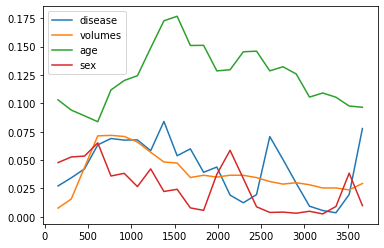

In [22]:
avg_norms.plot()

<AxesSubplot:>

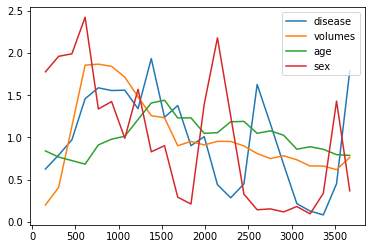

In [23]:
scaled_avg_norms.plot()

In [24]:
scale_parameters = 1/stats.loc['mean']
scale_parameters = scale_parameters/scale_parameters.sum()*4
scale_parameters

disease    0.975155
volumes    1.103015
age        0.345362
sex        1.576468
Name: mean, dtype: float64

nohup python training.py -bs 16 -lw 1.054807 1.607432 0.370006 0.967756 -d 0.2 &
nohup python training.py -e 100 --patience 100 -bs 16 -d 0.5 -lwp results/models/loss_weights.npy &

In [26]:
# loss_weights = np.array([1.054807, 1.607432, 0.370006, 0.967756])
loss_weights = scale_parameters.to_numpy()

In [28]:
np.save('results/models/loss_weights_t1l_without_bn.npy', loss_weights.astype(np.float32))

# Age investigation

In [ ]:
df = pd.concat([training_df, valid_df], ignore_index=True)
df2 = df_add_data.merge(df, on =['participant_id', 'session_id'], how='right')

In [ ]:
plt.title('Age Distribution')
plt.hist(training_df.age, label='training')
plt.hist(valid_df.age, label='validation')
plt.xlabel('age')
plt.legend()

# Results investigation

In [8]:
absolute_path = '/network/lustre/dtlake01/aramis/users/sasha.collin/interpretability-dl-ndd/results/models'
models = [ model for model in os.listdir(absolute_path) if 'model' in model ]
dicts = []
for model in models:
    f = open(os.path.join(absolute_path, model, 'commandline.json'),)
    d = json.load(f)
    d.update({'model': int(model[6:])})
    dicts.append(d)
parameters = pd.DataFrame(dicts)
parameters.sort_values('model', inplace=True)
parameters.to_csv('results/models/summary.csv', index=False)
parameters

,config_path,cpu,dropout,batch_size,debug,nb_epochs,num_workers,loss_weights_path,learning_rate,loss_weights,monitor,patience,preprocessing,resume_training,save_gradient_norm,seed,weight_decay,model,eval_mode,convolutions
36,NaN,NaN,0.2,4,NaN,30,8,NaN,0.0001,"[1.0, 0.0, 0.0, 0.0]",train,NaN,NaN,NaN,NaN,NaN,0.0001,5,NaN,NaN
18,NaN,NaN,0.2,4,NaN,30,8,NaN,0.0001,"[0.0, 1.0, 0.0, 0.0]",train,NaN,NaN,NaN,NaN,NaN,0.0001,6,NaN,NaN
49,NaN,NaN,0.2,4,NaN,30,8,NaN,0.0001,"[0.0, 0.0, 1.0, 0.0]",train,NaN,NaN,NaN,NaN,NaN,0.0001,7,NaN,NaN
12,NaN,NaN,0.2,4,NaN,30,8,NaN,0.0001,"[0.0, 0.0, 0.0, 1.0]",train,NaN,NaN,NaN,NaN,NaN,0.0001,8,NaN,NaN
68,NaN,NaN,0.2,4,NaN,8,8,NaN,0.0001,"[1.0, 0.0, 0.0, 0.0]",train,NaN,NaN,NaN,NaN,NaN,0.0001,9,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,None,False,0.5,4,False,85,8,results/models/loss_weights_t1l_without_bn.npy,0.0001,"[0.9751553878521984, 1.1030149734100396, 0.345...",train,75.0,t1-linear,False,False,0.0,0.0001,79,True,NaN
10,None,False,0.1,4,False,80,8,None,0.0001,"[1.0, 1.0, 1.0, 1.0]",train,75.0,t1-linear,False,False,0.0,0.0001,80,True,NaN
69,None,False,0.2,4,False,80,8,None,0.0001,"[1.0, 1.0, 1.0, 1.0]",train,75.0,t1-linear,False,False,0.0,0.0001,81,True,NaN
11,None,False,0.3,4,False,80,8,None,0.0001,"[1.0, 1.0, 1.0, 1.0]",train,75.0,t1-linear,False,False,0.0,0.0001,83,True,"[8, 16, 32, 64]"


In [9]:
parameters[-15:]

,config_path,cpu,dropout,batch_size,debug,nb_epochs,num_workers,loss_weights_path,learning_rate,loss_weights,monitor,patience,preprocessing,resume_training,save_gradient_norm,seed,weight_decay,model,eval_mode,convolutions
1,None,False,0.3,16,False,100,8,results/models/loss_weights.npy,0.0001,"[1.054807, 1.607432, 0.370006, 0.967756]",train,75.0,t1-volume,False,False,0.0,0.0001,68,False,NaN
46,None,False,0.5,16,False,100,8,results/models/loss_weights.npy,0.0001,"[1.054807, 1.607432, 0.370006, 0.967756]",train,75.0,t1-volume,False,False,0.0,0.0001,69,False,NaN
39,None,False,0.3,4,False,25,8,None,0.0001,"[1.0, 0.0, 0.0, 0.0]",train,70.0,t1-linear,False,True,0.0,0.0001,70,True,NaN
15,None,False,0.3,4,False,60,8,None,0.0001,"[1.0, 1.0, 1.0, 1.0]",train,75.0,t1-linear,False,False,0.0,0.0001,72,True,NaN
47,None,False,0.3,4,False,25,8,None,0.0001,"[0.0, 1.0, 0.0, 0.0]",train,70.0,t1-linear,False,True,0.0,0.0001,73,True,NaN
53,None,False,0.7,16,False,100,8,results/models/loss_weights.npy,0.0001,"[1.054807, 1.607432, 0.370006, 0.967756]",train,75.0,t1-volume,False,False,0.0,0.0001,74,False,NaN
67,None,False,0.3,4,False,25,8,None,0.0001,"[0.0, 0.0, 1.0, 0.0]",train,70.0,t1-linear,False,True,0.0,0.0001,75,True,NaN
71,None,False,0.3,4,False,25,8,None,0.0001,"[0.0, 0.0, 0.0, 1.0]",train,70.0,t1-linear,False,True,0.0,0.0001,76,True,NaN
17,None,False,0.3,4,False,85,8,results/models/loss_weights_t1l_without_bn.npy,0.0001,"[0.9751553878521984, 1.1030149734100396, 0.345...",train,75.0,t1-linear,False,False,0.0,0.0001,77,True,NaN
30,None,False,0.4,4,False,85,8,results/models/loss_weights_t1l_without_bn.npy,0.0001,"[0.9751553878521984, 1.1030149734100396, 0.345...",train,75.0,t1-linear,False,False,0.0,0.0001,78,True,NaN


## performances

In [19]:
def get_performances(models):
    """
    Params:
        - models: list of ints (model numbers)
    """
    if type(models) != list:
        models = [models]
    
    best_performances = pd.DataFrame({'model': []})
    for model in models:
        try:
            performances = pd.read_csv('results/models/model_{}/test_metrics.csv'.format(model))
        except:
            saved_data = torch.load('results/models/model_{}/last_model.pt'.format(model))
            performances = pd.DataFrame(saved_data['val_metrics'])
        best_performances = best_performances.append(performances[performances.test == performances.test.min()])
    best_performances.reset_index(inplace=True)
    #best_performances.drop(columns=['index'], inplace=True)
    best_performances['model'] = models
    return best_performances

In [20]:
perf = get_performances([72, 77, 78, 79, 80, 81, 83, 85])
perf

,index,model,disease,volumes,age,sex,test,b1_Accuracy,b1_F1,b1_AUROC,b2_MeanSquaredError,b2_R2Score,b3_MeanSquaredError,b3_R2Score,b4_Accuracy,b4_F1,b4_AUROC
0,20,72,0.090923,0.221217,0.173681,0.052454,0.538274,0.888158,0.888889,0.946354,0.051961,0.341011,5.832608,0.326477,0.934211,0.933333,0.990303
1,17,77,0.100209,0.226368,0.176956,0.032029,0.459013,0.894737,0.888889,0.936458,0.052569,0.325496,5.887350,0.313775,0.953947,0.954839,0.991861
2,13,78,0.087246,0.252608,0.187973,0.041201,0.493580,0.868421,0.864865,0.930035,0.055642,0.247357,6.067847,0.271053,0.934211,0.933333,0.990823
3,13,79,0.099093,0.242389,0.203839,0.027808,0.478227,0.855263,0.842857,0.903472,0.054445,0.277635,6.318741,0.209525,0.947368,0.948718,0.993420
4,53,80,0.097928,0.237659,0.163061,0.033962,0.532610,0.855263,0.857143,0.930382,0.053951,0.291082,5.651477,0.367660,0.960526,0.960526,0.990649
5,6,81,0.103611,0.229576,0.184643,0.033362,0.551193,0.848684,0.832117,0.912326,0.053112,0.314953,6.013856,0.283967,0.947368,0.948052,0.989437
6,70,83,0.172959,0.230539,0.181573,0.006916,0.591986,0.526316,0.000000,0.500000,0.053107,0.312330,5.963646,0.295874,0.986842,0.986842,1.000000
7,51,85,0.116838,0.210712,0.177086,0.034424,0.461780,0.842105,0.844156,0.921528,0.050627,0.371804,5.889508,0.313272,0.953947,0.955414,0.993420


In [23]:
perf['R2Score'] = perf['b2_R2Score'] + perf['b3_R2Score']
perf['total_test'] = perf['disease'] + perf['volumes'] + perf['age'] + perf['sex']

In [24]:
perf

,index,model,disease,volumes,age,sex,test,b1_Accuracy,b1_F1,b1_AUROC,b2_MeanSquaredError,b2_R2Score,b3_MeanSquaredError,b3_R2Score,b4_Accuracy,b4_F1,b4_AUROC,R2Score,total_test
0,20,72,0.090923,0.221217,0.173681,0.052454,0.538274,0.888158,0.888889,0.946354,0.051961,0.341011,5.832608,0.326477,0.934211,0.933333,0.990303,0.667488,0.538274
1,17,77,0.100209,0.226368,0.176956,0.032029,0.459013,0.894737,0.888889,0.936458,0.052569,0.325496,5.887350,0.313775,0.953947,0.954839,0.991861,0.639271,0.535562
2,13,78,0.087246,0.252608,0.187973,0.041201,0.493580,0.868421,0.864865,0.930035,0.055642,0.247357,6.067847,0.271053,0.934211,0.933333,0.990823,0.518409,0.569029
3,13,79,0.099093,0.242389,0.203839,0.027808,0.478227,0.855263,0.842857,0.903472,0.054445,0.277635,6.318741,0.209525,0.947368,0.948718,0.993420,0.487160,0.573129
4,53,80,0.097928,0.237659,0.163061,0.033962,0.532610,0.855263,0.857143,0.930382,0.053951,0.291082,5.651477,0.367660,0.960526,0.960526,0.990649,0.658741,0.532610
5,6,81,0.103611,0.229576,0.184643,0.033362,0.551193,0.848684,0.832117,0.912326,0.053112,0.314953,6.013856,0.283967,0.947368,0.948052,0.989437,0.598920,0.551193
6,70,83,0.172959,0.230539,0.181573,0.006916,0.591986,0.526316,0.000000,0.500000,0.053107,0.312330,5.963646,0.295874,0.986842,0.986842,1.000000,0.608203,0.591986
7,51,85,0.116838,0.210712,0.177086,0.034424,0.461780,0.842105,0.844156,0.921528,0.050627,0.371804,5.889508,0.313272,0.953947,0.955414,0.993420,0.685075,0.539059


In [52]:
model = 'model_72'
train_csv = pd.read_csv('results/models/{}/train_metrics.csv'.format(model))
val_csv = pd.read_csv('results/models/{}/test_metrics.csv'.format(model))

<AxesSubplot:>

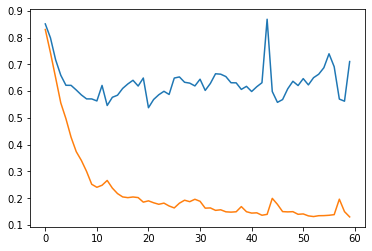

In [54]:
val_csv['test'].plot()
train_csv['train'].plot()

In [47]:
val = pd.read_csv('/network/lustre/dtlake01/aramis/users/sasha.collin/interpretability-dl-ndd/results/models/model_19/test_metrics.csv')
val

,disease,volumes,age,sex,test,b1_Accuracy,b1_F1,b1_AUROC,b2_MeanSquaredError,b2_R2Score,b3_MeanSquaredError,b3_R2Score,b4_Accuracy,b4_F1,b4_AUROC
0,0.165219,5.125420,0.588990,0.135237,2.226931,0.631579,0.582090,0.651563,0.258117,-14.885667,10.740900,-1.284064,0.743421,0.692913,0.870303
1,0.156860,1.125695,0.357736,0.156100,0.570194,0.638158,0.598540,0.707118,0.117883,-2.518233,8.370815,-0.387275,0.769737,0.785276,0.852987
2,0.236548,2.005762,5.872990,0.121019,1.394216,0.671053,0.609375,0.690278,0.144386,-5.309240,33.916916,-21.775061,0.796053,0.797386,0.884675
3,0.161303,2.104267,34.566440,0.164127,3.745328,0.703947,0.634146,0.746701,0.158088,-5.585790,82.283737,-133.046310,0.828947,0.814286,0.906840
4,0.331431,3.486454,4.228611,0.146323,1.901789,0.736842,0.655172,0.787847,0.206235,-9.806895,28.779650,-15.398264,0.809211,0.807947,0.879480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.102221,0.266186,0.158655,0.052322,0.163539,0.802632,0.800000,0.896875,0.057177,0.205612,5.574606,0.384745,0.940789,0.942675,0.988571
76,0.084728,0.227850,0.168179,0.053638,0.143639,0.901316,0.896552,0.938715,0.054074,0.334712,5.739478,0.347814,0.921053,0.917808,0.989437
77,0.074076,0.233241,0.165499,0.047260,0.141107,0.894737,0.888889,0.957292,0.054637,0.316420,5.693564,0.358206,0.921053,0.920000,0.989784
78,0.080645,0.219286,0.165243,0.051431,0.138205,0.861842,0.859060,0.945660,0.053240,0.361197,5.689159,0.359199,0.947368,0.947368,0.981472


In [48]:
val[val.test == val.test.min()]

,disease,volumes,age,sex,test,b1_Accuracy,b1_F1,b1_AUROC,b2_MeanSquaredError,b2_R2Score,b3_MeanSquaredError,b3_R2Score,b4_Accuracy,b4_F1,b4_AUROC
78,0.080645,0.219286,0.165243,0.051431,0.138205,0.861842,0.85906,0.94566,0.05324,0.361197,5.689159,0.359199,0.947368,0.947368,0.981472


In [40]:
val[val.test == val.test.min()]

,disease,volumes,age,sex,test,b1_Accuracy,b1_F1,b1_AUROC,b2_MeanSquaredError,b2_R2Score,b3_MeanSquaredError,b3_R2Score,b4_Accuracy,b4_F1,b4_AUROC
32,0.028161,0.058482,0.05743,0.030029,0.17402,0.743421,0.715329,0.809332,0.052802,0.320126,6.598213,0.138055,0.763158,0.764706,0.845974


In [38]:
val[val.test == val.test.min()]

,disease,volumes,age,sex,test,b1_Accuracy,b1_F1,b1_AUROC,b2_MeanSquaredError,b2_R2Score,b3_MeanSquaredError,b3_R2Score,b4_Accuracy,b4_F1,b4_AUROC
20,0.090923,0.221217,0.173681,0.052454,0.538274,0.888158,0.888889,0.946354,0.051961,0.341011,5.832608,0.326477,0.934211,0.933333,0.990303


## other

In [71]:
#path = 'network/lustre/dtlake01/aramis/users/sasha.collin/interpretability-dl-ndd/results/models/model_32'
model = 'model_26'
training_df = pd.read_csv('/network/lustre/dtlake01/aramis/users/sasha.collin/interpretability-dl-ndd/results/models/{}/training_df.csv'.format(model))
valid_df = pd.read_csv('/network/lustre/dtlake01/aramis/users/sasha.collin/interpretability-dl-ndd/results/models/{}/valid_df.csv'.format(model))

train_transforms, all_transforms = get_transforms('image', minmaxnormalization=True, data_augmentation=None)
# fetch volumetric data
stds, df_add_data = fetch_add_data(training_df)

First column name:  t1-volume_group-adni2021_atlas-AAL2_ROI-Background_intensity
Last column name:  t1-volume_group-adni2021_atlas-AAL2_ROI-Vermis_10_intensity
     participant_id session_id sex   age  \
0  sub-ADNI002S0295    ses-M00   M  84.8   
1  sub-ADNI002S0295    ses-M06   M  85.3   
2  sub-ADNI002S0295    ses-M12   M  85.8   
3  sub-ADNI002S0295    ses-M24   M  87.0   
4  sub-ADNI002S0295    ses-M36   M  87.8   

   t1-volume_group-adni2021_atlas-AAL2_ROI-Precentral_L_intensity  \
0                                           0.267730                
1                                           0.276336                
2                                           0.253523                
3                                           0.259355                
4                                           0.284153                

   t1-volume_group-adni2021_atlas-AAL2_ROI-Precentral_R_intensity  \
0                                           0.219289                
1                     

In [72]:
caps_directory = '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021/'
# build MRI datasets
data_train = MRIDatasetImage(caps_directory, training_df, df_add_data=df_add_data, preprocessing='t1-volume',
                             all_transformations=all_transforms)  # train_transformations=all_transforms
data_valid = MRIDatasetImage(caps_directory, valid_df, df_add_data=df_add_data, preprocessing='t1-volume',
                             all_transformations=all_transforms)  # train_transformations=all_transforms,

In [73]:
batch_size = 8

valid_loader = DataLoader(data_valid,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=8,
                          pin_memory=True)

train_loader = DataLoader(data_train,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=8,
                          pin_memory=True)

In [109]:
model = 'model_26'
saved_data = torch.load(os.path.join('/network/lustre/dtlake01/aramis/users/sasha.collin/interpretability-dl-ndd/results/models/' + model, 'last_model.pt'))
# get sample
sample = data_train[0]
# build model
model = Net(sample, [8, 16, 32, 64, 128], 0.3).cuda()
# load pretrained weights on validation set
# saved_data = torch.load(os.path.join(args.model_path, 'test_best_model.pt'))
model.load_state_dict(saved_data['model_state_dict'])

<All keys matched successfully>

In [67]:
model.train()
model.training

True

In [113]:
model.summary()

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      --                        --
├─Sequential: 1-1                        [1, 64, 5, 7, 5]          --
│    └─Conv3d: 2-1                       [1, 8, 119, 143, 119]     224
│    └─ReLU: 2-2                         [1, 8, 119, 143, 119]     --
│    └─BatchNorm3d: 2-3                  [1, 8, 119, 143, 119]     16
│    └─MaxPool3d: 2-4                    [1, 8, 59, 71, 59]        --
│    └─Conv3d: 2-5                       [1, 16, 57, 69, 57]       3,472
│    └─ReLU: 2-6                         [1, 16, 57, 69, 57]       --
│    └─BatchNorm3d: 2-7                  [1, 16, 57, 69, 57]       32
│    └─MaxPool3d: 2-8                    [1, 16, 28, 34, 28]       --
│    └─Conv3d: 2-9                       [1, 32, 26, 32, 26]       13,856
│    └─ReLU: 2-10                        [1, 32, 26, 32, 26]       --
│    └─BatchNorm3d: 2-11                 [1, 32, 26, 32, 26]       64
│    └─

In [112]:
resu = test(model,
     valid_loader,
     loss_weights= [1, 1, 1, 1], #np.array([1.054807, 1.607432, 0.370006, 0.967756]),
     to_cuda=True,
     rescaling=stds,
     compute_metrics=True,
     eval_mode=False)

Eval mode: not activated.
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
Test set loss: 0.4074, Accuracy: 80.26


In [111]:
resu

{'disease': 0.07635193835257699,
 'volumes': 0.13538574348939092,
 'age': 0.13697640862511962,
 'sex': 0.06317884024036557,
 'test': 0.4118929301437579,
 'b1_Accuracy': 0.6677631735801697,
 'b1_F1': 0.6405694484710693,
 'b1_AUROC': 0.6858940720558167,
 'b2_MeanSquaredError': 0.05599762871861458,
 'b2_R2Score': 0.21226301789283752,
 'b3_MeanSquaredError': 6.869096279144287,
 'b3_R2Score': 0.06582951545715332,
 'b4_Accuracy': 0.8026315569877625,
 'b4_F1': 0.7986577749252319,
 'b4_AUROC': 0.8787878155708313}

In [120]:
saved_data = torch.load(os.path.join('/network/lustre/dtlake01/aramis/users/sasha.collin/interpretability-dl-ndd/results/models/' + 'model_63', 'last_model.pt'))

In [123]:
pd.DataFrame(saved_data['train_metrics'])

,disease,volumes,age,sex,train,b1_Accuracy,b1_F1,b1_AUROC,b2_MeanSquaredError,b2_R2Score,b3_MeanSquaredError,b3_R2Score,b4_Accuracy,b4_F1,b4_AUROC
0,0.043420,0.065361,0.062777,0.044828,0.217473,0.542484,0.274611,0.576858,0.056771,-0.019450,6.978149,0.003958,0.478758,0.640361,0.464605
1,0.039606,0.063549,0.057768,0.044118,0.207996,0.665033,0.580777,0.739591,0.056132,0.003459,6.657384,0.093424,0.516340,0.625316,0.568568
2,0.033991,0.061969,0.054628,0.042658,0.196961,0.776144,0.755793,0.845845,0.055250,0.031714,6.422543,0.156256,0.612745,0.662873,0.645502
3,0.029815,0.056850,0.049947,0.041627,0.181597,0.790850,0.768953,0.881034,0.052798,0.107995,6.054920,0.250082,0.622549,0.648402,0.669647
4,0.025592,0.049752,0.045527,0.040090,0.162610,0.839869,0.829268,0.916331,0.048976,0.223336,5.920895,0.282913,0.669935,0.672078,0.717821
5,0.021415,0.043553,0.038845,0.037354,0.143120,0.879085,0.870629,0.951157,0.045836,0.314179,5.495769,0.382192,0.714052,0.712644,0.789209
6,0.017063,0.038799,0.032374,0.033378,0.124645,0.898693,0.893103,0.972253,0.043015,0.388166,4.999117,0.488809,0.777778,0.767918,0.864679
7,0.012632,0.034884,0.033177,0.026929,0.107734,0.942810,0.939759,0.986432,0.040765,0.448154,5.077826,0.472585,0.841503,0.841244,0.924455
8,0.009527,0.034483,0.031569,0.023990,0.100376,0.968954,0.967185,0.994549,0.040380,0.457763,4.937012,0.501431,0.874183,0.873563,0.940481
9,0.009078,0.032972,0.027600,0.018445,0.090639,0.960784,0.958188,0.993221,0.039487,0.480562,4.614020,0.564532,0.906863,0.905473,0.973900


## investigating df_add_data

In [43]:
# paths
data_path = '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021.tsv'
summary_path = '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021_summary.tsv'

# fetch indexes
df_summary = pd.read_csv(summary_path, sep='\t')
df_summary = df_summary[(df_summary.pipeline_name == pipeline_name) & (df_summary.atlas_id == atlas_id)]
first_column_name = df_summary.first_column_name.item()
last_column_name = df_summary.last_column_name.item()
print('First column name: ', first_column_name)
print('Last column name: ', last_column_name)
df_data = pd.read_csv(data_path, sep='\t', nrows=1)
first_column_index = df_data.columns.get_loc(first_column_name)
last_column_index = df_data.columns.get_loc(last_column_name)

# other data to fetch
col_names = ['participant_id', 'session_id', 'sex', 'age']
add_indexes = [df_data.columns.get_loc(col_name) for col_name in col_names]

# compute df_add_data
# add 1 to first_column_index to ignore background
used_columns = np.hstack([add_indexes, np.arange(first_column_index + 1, last_column_index + 1)]).flatten()
df_add_data = pd.read_csv(data_path, sep='\t', usecols=used_columns).dropna(axis=0, how='any')
print(df_add_data.head())

First column name:  t1-volume_group-adni2021_atlas-AAL2_ROI-Background_intensity
Last column name:  t1-volume_group-adni2021_atlas-AAL2_ROI-Vermis_10_intensity


In [55]:
# normalization using only statistics from training data
temp_df = pd.merge(training_data[['participant_id', 'session_id']],
                   df_add_data, on=['participant_id', 'session_id'], how='left')

In [75]:
scalar_cols = [col for col in temp_df.columns if col not in ['participant_id', 'session_id', 'sex']]
# df_add_data[scalar_cols] contains only scalar columns with (patient, session) from training set
means, stds = temp_df[scalar_cols].mean(), temp_df[scalar_cols].std()
df_add_data[scalar_cols] = (df_add_data[scalar_cols] - means) / stds

In [76]:
df_add_data[scalar_cols]

,age,t1-volume_group-adni2021_atlas-AAL2_ROI-Precentral_L_intensity,t1-volume_group-adni2021_atlas-AAL2_ROI-Precentral_R_intensity,t1-volume_group-adni2021_atlas-AAL2_ROI-Frontal_Sup_2_L_intensity,t1-volume_group-adni2021_atlas-AAL2_ROI-Frontal_Sup_2_R_intensity,t1-volume_group-adni2021_atlas-AAL2_ROI-Frontal_Mid_2_L_intensity,t1-volume_group-adni2021_atlas-AAL2_ROI-Frontal_Mid_2_R_intensity,t1-volume_group-adni2021_atlas-AAL2_ROI-Frontal_Inf_Oper_L_intensity,t1-volume_group-adni2021_atlas-AAL2_ROI-Frontal_Inf_Oper_R_intensity,t1-volume_group-adni2021_atlas-AAL2_ROI-Frontal_Inf_Tri_L_intensity,...,t1-volume_group-adni2021_atlas-AAL2_ROI-Cerebelum_10_L_intensity,t1-volume_group-adni2021_atlas-AAL2_ROI-Cerebelum_10_R_intensity,t1-volume_group-adni2021_atlas-AAL2_ROI-Vermis_1_2_intensity,t1-volume_group-adni2021_atlas-AAL2_ROI-Vermis_3_intensity,t1-volume_group-adni2021_atlas-AAL2_ROI-Vermis_4_5_intensity,t1-volume_group-adni2021_atlas-AAL2_ROI-Vermis_6_intensity,t1-volume_group-adni2021_atlas-AAL2_ROI-Vermis_7_intensity,t1-volume_group-adni2021_atlas-AAL2_ROI-Vermis_8_intensity,t1-volume_group-adni2021_atlas-AAL2_ROI-Vermis_9_intensity,t1-volume_group-adni2021_atlas-AAL2_ROI-Vermis_10_intensity
0,-10.371078,-6.755787,-17.448540,-9.856215,1.308854,-4.060409,-8.537109,17.364102,9.181010,14.122580,...,37.450430,32.003362,-0.395547,8.592446,15.506310,28.332810,32.156244,3.515990,2.249526,1.866363
1,-10.360867,-2.166231,-13.553991,-5.914116,6.821384,-1.919121,-5.905258,18.719932,15.175435,18.967978,...,58.955149,46.133386,24.599699,9.741241,19.226676,33.884257,32.643009,5.744026,8.882040,74.955580
2,-10.350657,-14.333127,-23.529742,-10.118421,1.654507,-4.121273,-8.032142,16.884448,12.636779,17.425437,...,44.954601,36.412082,10.092355,13.603969,18.237147,28.470831,25.620468,2.417680,8.051755,46.150101
3,-10.326151,-11.222651,-17.821794,-9.865694,2.715897,-4.994070,-8.440397,17.311027,11.961089,14.261600,...,34.692114,47.833779,7.433017,11.708185,9.454692,31.346144,30.784380,9.692112,8.504351,36.049454
4,-10.309814,2.003125,-15.843389,-9.855342,-0.698365,-5.767547,-12.016290,15.360080,10.938706,8.498243,...,37.701690,36.328328,10.260215,11.662493,11.452707,19.564331,20.435166,4.045704,1.976461,45.879493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16309,-10.581419,16.186787,22.075125,23.548859,27.409276,16.065701,34.145793,0.567164,7.843143,14.850995,...,-50.672729,-22.568044,41.555361,16.718336,23.147099,15.138159,7.010295,3.748973,-1.584924,47.192880
16311,-10.471143,-20.702211,-24.113782,-48.024891,-50.806599,-30.559320,-28.992084,-28.331114,-31.351959,-27.833020,...,10.946551,0.104284,-43.344625,-51.779829,-35.457592,-2.023009,-17.884224,-19.965198,-26.052668,-133.530645
16312,-10.450722,-13.170785,-18.186610,-46.453907,-48.319219,-28.669190,-26.240904,-29.447806,-31.963987,-27.189085,...,6.208774,-8.336758,-37.064970,-43.342571,-32.902367,-1.348215,-11.783608,-17.091668,-20.391152,-103.309417
16314,-10.583461,20.552611,6.155411,-4.036766,6.026326,-4.777998,-5.965431,-6.351540,-1.174190,27.098433,...,-24.032538,-46.309416,-28.040706,-31.515861,-20.392107,-34.046549,-27.295519,-8.655179,7.715651,29.257953


In [79]:
pd.read_csv('/network/lustre/dtlake01/aramis/users/sasha.collin/interpretability-dl-ndd/results/models/model_39/train_metrics.csv')

,disease,volumes,age,sex,train,b1_Accuracy,b1_F1,b1_AUROC,b2_MeanSquaredError,b2_R2Score,b3_MeanSquaredError,b3_R2Score,b4_Accuracy,b4_F1,b4_AUROC
0,0.045325,0.092974,0.089199,0.048100,0.275598,0.570261,0.527828,0.573131,0.067698,-0.455270,8.311589,-0.413074,0.501634,0.559885,0.504947
1,0.039934,0.090333,0.077058,0.044640,0.251965,0.642157,0.621762,0.704359,0.066231,-0.394755,7.748322,-0.228039,0.557190,0.611191,0.588173
2,0.038301,0.086071,0.070525,0.042587,0.237485,0.674837,0.642729,0.740287,0.065328,-0.349238,7.387534,-0.116338,0.589869,0.634643,0.644316
3,0.037357,0.080854,0.069691,0.041988,0.229890,0.697712,0.666667,0.761448,0.063280,-0.275512,7.319338,-0.095823,0.604575,0.650289,0.670224
4,0.036822,0.075928,0.060611,0.040880,0.214240,0.714052,0.684685,0.777179,0.061332,-0.198370,6.847606,0.040877,0.651961,0.686303,0.699776
5,0.034838,0.071743,0.057329,0.036975,0.200884,0.702614,0.682927,0.797665,0.059038,-0.116750,6.646929,0.096270,0.700980,0.730486,0.778761
6,0.031907,0.065208,0.048461,0.036001,0.181577,0.764706,0.742857,0.842140,0.056517,-0.025206,6.147194,0.227051,0.730392,0.748092,0.801368
7,0.030243,0.059636,0.049818,0.034237,0.173933,0.794118,0.781250,0.869865,0.054104,0.059504,6.131954,0.230879,0.743464,0.760305,0.831207
8,0.027899,0.056010,0.046953,0.031780,0.162641,0.841503,0.830716,0.901499,0.052245,0.118587,5.992855,0.265377,0.779412,0.798808,0.877244
9,0.026518,0.052745,0.039293,0.029405,0.147961,0.857843,0.849741,0.926162,0.050464,0.176741,5.526847,0.375185,0.815359,0.827481,0.909893


In [80]:
pd.read_csv('/network/lustre/dtlake01/aramis/users/sasha.collin/interpretability-dl-ndd/results/models/model_39/test_metrics.csv')

,disease,volumes,age,sex,test,b1_Accuracy,b1_F1,b1_AUROC,b2_MeanSquaredError,b2_R2Score,b3_MeanSquaredError,b3_R2Score,b4_Accuracy,b4_F1,b4_AUROC
0,0.052918,0.367739,0.100622,0.048625,0.569904,0.473856,0.643016,0.620111,0.133678,-4.768250,8.716296,-0.554035,0.490196,0.657895,0.457885
1,0.044064,0.088605,0.082481,0.041907,0.257057,0.557190,0.675449,0.767905,0.066256,-0.392598,8.010746,-0.312631,0.625817,0.639370,0.659776
2,0.037936,0.082798,0.052633,0.042163,0.215529,0.756536,0.742660,0.839955,0.064212,-0.305101,6.409377,0.159712,0.598039,0.699266,0.733729
3,0.047586,0.079789,0.052272,0.039641,0.219288,0.718954,0.635593,0.818045,0.062093,-0.234524,6.376223,0.168382,0.673203,0.736842,0.795203
4,0.049160,0.971830,0.393760,0.036837,1.451588,0.748366,0.758621,0.823196,0.218792,-14.554193,17.531031,-5.286540,0.738562,0.722222,0.827436
5,0.031653,0.173783,1.947765,0.034341,2.187542,0.764706,0.772152,0.874020,0.092904,-1.771827,39.061535,-30.210123,0.761438,0.792614,0.873259
6,0.029428,0.188652,1.918990,0.031394,2.168463,0.818627,0.824645,0.910591,0.098777,-2.010370,38.772987,-29.750731,0.821895,0.830482,0.908098
7,0.025370,0.046713,2.981720,0.029264,3.083067,0.885621,0.880952,0.950161,0.047751,0.261499,48.331322,-46.780876,0.852941,0.860248,0.935929
8,0.025716,0.046543,0.039652,0.026690,0.138601,0.892157,0.887372,0.956072,0.047215,0.274732,5.475681,0.386700,0.893791,0.900459,0.969423
9,0.022886,0.043741,1.578576,0.028347,1.673550,0.928105,0.924658,0.975744,0.045962,0.312050,35.155968,-24.281046,0.915033,0.919255,0.978312


# Hyperparameters tuning

In [13]:
path = 'results/models'
model_numbers = np.arange(47, 51)

In [22]:
dfs = [pd.read_csv(os.path.join(path, 'model_' + str(k), 'test_metrics.csv')) for k in model_numbers]
dfs_train = [pd.read_csv(os.path.join(path, 'model_' + str(k), 'train_metrics.csv')) for k in model_numbers]

In [23]:
for k in range(4):
    print(dfs_train[k]['train'].min(), dfs_train[k]['b2_R2Score'].max(), dfs_train[k]['b3_R2Score'].max())

0.0329709329149302 0.7540770769119263 0.8676573634147644
0.0442458947304806 0.6845685839653015 0.7994126677513123
0.0547965516646703 0.635993480682373 0.7386859059333801
0.037945926871175 0.7125221490859985 0.8559098243713379


In [21]:
for k in range(4):
    print(dfs[k]['test'].min(), dfs[k]['b2_R2Score'].max(), dfs[k]['b3_R2Score'].max())

0.2045990401192715 0.2628269791603088 0.2623510360717773
0.198367020801494 0.2596933841705322 0.279445469379425
0.1889909992092534 0.2638071179389953 0.2332614660263061
0.2035861940760361 0.2700107395648956 0.2089001536369323


# RANDOM

I am using working with the file '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021.tsv' and using the 't1-volume' pipeline and the atlas 'AAL2'.
6267 samples (i.e. couples (participant_id, session_id)) do not have any volume value (i.e. NaN). 1 sample has no sex value and 1178 samples have no age values.
